In [114]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, patches
import matplotlib
from scipy.signal import argrelextrema

# Set graphing params.
sns.set()
matplotlib.rcParams['figure.figsize'] = (25.0, 10.0)

### Munging functions
These are helper functions. Columns are renamed to a standard format:

Header | Value    
   --- | --- 
f | Raw force (N)
mdia | Muscle diameter (in)
msgtype | N/A
pwm | Digital PWM value
rc | Constant
rw | Constant
t  | Temperature
t0 | Starting temperature
timestamp | Absolute time (s)

In [2]:
# Renames columns to standard format listed above,
# Normalizes timestamps relative to 0 (instead of experiment start time),
# Fills NaNs, inverts force.
def clean(df):
    df.columns = ["f", "mdia", "msgtype", "pwm", "rc", "rw", "t", "t0", "timestamp"]
    if(df.iloc[0].timestamp > 0):
        df.timestamp -= df.iloc[0].timestamp
    df.pwm.replace(to_replace=0, value=np.NaN, inplace=True)
    df.f = -df.f
    return df.fillna(0)

In [3]:
# Grabs rolling average with default lag of 300-points.
# You can set #points in rolling window with `window` param, and
# select whether to add the rolling average column to the given 
# dataframe with `add_col` param.
def ma(df, window=300, add_col=True):
    m = df.f.rolling(window=window).mean()
    if add_col:
        df['f_ra'] = m
        return df.fillna(0)
    return m

In [141]:
# Grabs minima and maxima.
# This is its own function only because this is an expensive operation.
# If param `return_indices` is True, then returns an ndarray of indices at which extrema occur.
# Else returns timestamps at which extrema occur.
def get_extrema(df, order=3000, return_indices=True):
    maxima = argrelextrema(df.f.values, np.greater, order=order)
    minima = argrelextrema(df.f.values, np.less, order=order)
    if return_indices:
        return minima, maxima
    return df.iloc[minima[0].tolist(), :].t, df.iloc[maxima[0].tolist(), :].t

In [137]:
# Labels cycles based on local (force) minima and maxima.
def label_cycles(df, minima, maxima, plot_extrema=True, plot_boxes=True):
    # Plot line connecting all minima, and another line connecting all maxima.
    fig, ax = plt.subplots(figsize=(25, 8), nrows=1, ncols=1)
    if plot_extrema:
        ax.plot(df.f, alpha=0.3); ax.plot(df.f.iloc[maxima[0].tolist()]); ax.plot(df.f.iloc[minima[0].tolist()])
    
    # Label cycles.
    df['cycle'] = -1
    for i in range(minima[0].size-1):
        rng = list(range(minima[0][i], minima[0][i+1]))
        df.iloc[rng, df.columns.get_loc('cycle')] = i # I don't know why `iloc` succeeds while `loc` fails here.
  
    # Draw bounding boxes around each cycle.
    if plot_boxes:
        for i in minima[0].tolist():
            ax.add_patch(patches.Rectangle((i, df.f.min()), df[df.cycle==i].shape[0], df.f.max()-df.f.min(), linewidth=1, edgecolor='r', facecolor='none', alpha=0.3, linestyle='-.'))
    return df

---

# Datasets
We inspect trials from `11/06` and `11/16`. For `11/06`:

$$
d=1in\\
\textrm{Duty cycle}=150ms\\
f_{min}=5N\\
f_{max}=40N\\
R=27.5\Omega\\
T=4.5hrs\\
c=40
$$

The `11/16` trial is similar, but lasts for
$$
c=100
$$
possibly due to conductive paste in the silicon.

In [91]:
# X_40 is a dataset with estimated 40 cycles.
X_40 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data_2018-11-06-22-59-57.msgpack"))))

In [ ]:
# X_100 is a dataset with estimated 100 cycles and conductive paste in silicon skin.
X_100 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data_2018-11-16-21-07-24.msgpack"))))

## Label cycles.

In [139]:
minima, maxima = get_extrema(X_40)

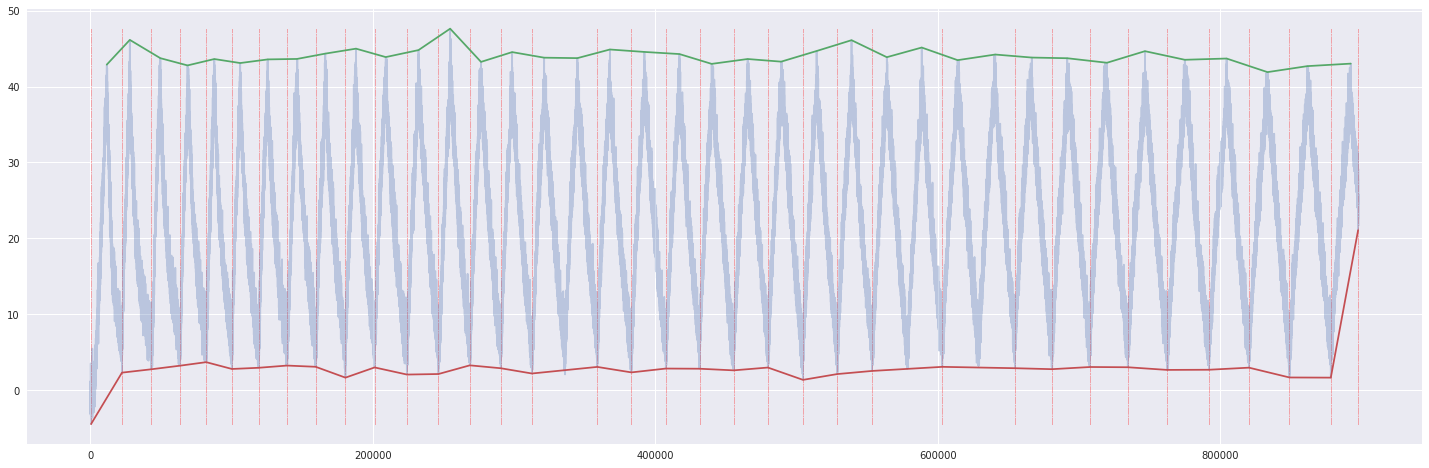

In [140]:
X_40 = label_cycles(X_40, minima, maxima)

## Fix period and stationarity.
Mean, variance, and autocorrelation of each cycle are not quite constant. We can't usefully determine correlation between variables until stationarity is maintained. We can eliminate stationarity by differencing data:
$$
Y_i = Z_i - Z_{i-1} \quad \forall i\in0, \dots,T
$$
or by fitting a trend and removing residuals:
$$
Y = a + bln\,X
$$

## Force stats over time.
Is force variance still accumulating (heteroscedatic) with conductive paste?

## Cyclic temperature
and correlation with force.